# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [15]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
import scipy.linalg
from urllib.request import urlretrieve

In [16]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [17]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt', encoding = 'utf-8') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        # if the word in our dict we return the embedding loaded
        # otherwise we return a 1D unifrom random array with the same shape (300)
            return self.embeddings[self.word2id[word]]
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        v1 = self.encode(word1)
        v2 = self.encode(word2)
        return np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort
        # we compute the scores between word and all the others words
        scores = [ self.score(word, word2) for word2 in self.words] 
        #we use np.argsort to have indxs of the sorted list
        #and we invert the array to have a decreasing order
        idxs = np.argsort(scores)[::-1]
        # we don't take the first word because it s the same word
        return [self.id2word[i] for i in idxs[1:k+1]]

In [18]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=100000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 100000 pretrained word vectors
cat tree 0.26449754661654756
cat dog 0.7078641298542564
cat pet 0.6753313359976382
Paris France 0.6892958925806543
Paris Germany 0.4051242286737549
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348003
['cats', 'kitty', 'kitten', 'feline', 'dog']
['dogs', 'puppy', 'pup', 'canine', 'pet']
['dog', 'cats', 'canines', 'doggies', 'puppies']
['France', 'Parisian', 'Marseille', 'Brussels', 'Marseilles']
['Austria', 'Europe', 'Berlin', 'Hamburg', 'Bavaria']


In [56]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        idf = {}
        occ = defaultdict(int)
        for sentence in sentences :
            for word in set(sentence.split()):
                occ[word]+=1
        for word in occ.keys():
            idf[word] = np.log10(len(sentences))/occ[word]
        return idf
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        # we ignored the words that doesn't exist in the embedding used
        word_vectors = np.array(list(self.word2vec.encode(word) for word in sentence.split() if word in self.word2vec.words))
        if idf is None:
            # mean of word vectors
            out = np.mean(word_vectors,axis=0)
        else:
            # idf-weighted mean of word vectors
            weights_idf = [idf[word] for word in sentence.split() if word in self.word2vec.words ]
            out = np.average(word_vectors, weights = weights_idf, axis=0)
        return out
    
    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm 
        v1 = self.encode(sentence1,idf)
        v2 = self.encode(sentence2,idf)
        return np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        query = self.encode(sentence, idf)
        keys = np.vstack([self.encode(sentence, idf) for sentence in sentences])
        scores = [self.score(sentence,sentence2,idf) for sentence2 in sentences]
        idxs = np.argsort(scores)[::-1]
        return [sentences[i] for i in idxs[:k]]
        

In [57]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7065220648251475
1 smiling african american boy . 
1) 1 smiling african american boy . 
2) 2 woman dancing while pointing . 
3) 5 women and 1 man are smiling for the camera . 
4) a small boy following 4 geese . 
5) 2 female babies eating chips . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.4511104540877974
2 female babies eating chips . 
1) 2 female babies eating chips . 
2) an old man with a bag of chips sits with a younger man holding a drink . 
3) old man eating meat and chips . 
4) the man is drinking beer while the other one eats chips . 
5) a man in blue is working on a wood project , and the wood chips are going into a green can . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [58]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        words_en = self.en_word2vec.words
        words_fr = self.fr_word2vec.words
        common_words = set(words_en).intersection(set(words_fr))
        X = np.concatenate([self.fr_word2vec.encode(word).reshape(1,-1) for word in common_words ]).T
        Y = np.concatenate([self.en_word2vec.encode(word).reshape(1,-1) for word in common_words ]).T

        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        U,s,V = scipy.linalg.svd(Y.dot(X.T))
        W = U.dot(V)
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        # we search the index of the word in fr_word2vec.words
        index = None
        for i in range(len(self.fr_word2vec.words)):
            if self.fr_word2vec.words[i] == fr_word : index = i
        if index == None :
            raise Exception('The word to be translated does not exist in the dictionary')
        trans_embed =  self.aligned_fr_embeddings[index]    
        scores = [np.dot(trans_embed,self.en_word2vec.encode(eng_word))/(np.linalg.norm(trans_embed)*np.linalg.norm(self.en_word2vec.encode(eng_word)))
                 for eng_word in self.en_word2vec.words]
        idxs = np.argsort(scores)[::-1]
        return [self.en_word2vec.id2word[i] for i in idxs[:k]]

In [59]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [60]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

word2vec = Word2Vec(en_embeddings_path, vocab_size=100000)
sentence2vec = BagOfWords(word2vec)

# TYPE CODE HERE
def load_data(path):
    raw = []
    y = []
    with open(path, encoding='utf-8') as f:
        for line in f:
            tokens = line.split()
            y.append(int(tokens[0]))
            #we delete the words that didn't figure in our dictionnaire
            sentence = ' '.join(word for word in tokens[1:] if word in word2vec.words)
            raw.append(sentence)
    return raw, y   

def load_data_test(path):
    raw = []
    with open(path, encoding='utf-8') as f:
        for line in f:
            tokens = line.split()
            sentence = ' '.join(word for word in tokens if word in word2vec.words)
            raw.append(sentence)
    return raw

train_raw, y_train = load_data(train_filepath)
dev_raw, y_dev = load_data(dev_filepath)
test_raw= load_data_test(test_filepath)

Loaded 100000 pretrained word vectors


In [61]:
# 2 - Encode sentences with the BoV model above
# TYPE CODE HERE

X_train_bov = [sentence2vec.encode(sentence) for sentence in train_raw]
idf_train = sentence2vec.build_idf(train_raw)
X_train_bov_idf = [sentence2vec.encode(sentence,idf_train) for sentence in train_raw]

X_dev_bov = [sentence2vec.encode(sentence) for sentence in dev_raw]
idf_dev = sentence2vec.build_idf(train_raw + dev_raw)
X_dev_bov_idf = [sentence2vec.encode(sentence,idf_dev) for sentence in dev_raw]

X_test_bov = [sentence2vec.encode(sentence) for sentence in dev_raw]
idf_test = sentence2vec.build_idf(train_raw + dev_raw + test_raw)
X_test_bov_idf = [sentence2vec.encode(sentence,idf_test) for sentence in test_raw]

Accuracy on train set with best parameter C=14.9520 without idf: 0.476241
Accuracy on train set with best parameter C=0.6158 with idf: 0.415145


Accuracy on dev set with best parameter C=14.9520 without idf: 0.419619
Accuracy on dev set with best parameter C=0.6158 with idf: 0.367847


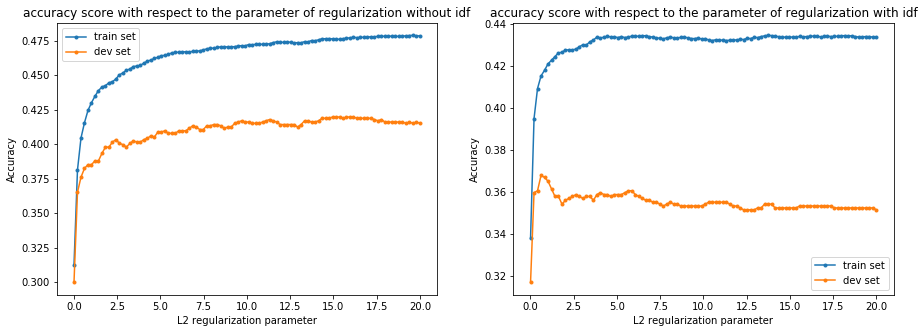

In [79]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

#without idf 
#list of regularization parameter C
Cs = np.linspace(0.01, 20, 100)
accuracy_train = []
accuracy_dev = []
for C in Cs:
    cl = LogisticRegression(penalty="l2", C=C , solver='liblinear',multi_class='ovr')
    cl.fit(X_train_bov, y_train)
    accuracy_train.append(cl.score(X_train_bov, y_train))
    accuracy_dev.append(cl.score(X_dev_bov, y_dev))

#with idf
accuracy_train_idf = []
accuracy_dev_idf = []
for C in Cs:
    cl = LogisticRegression(penalty="l2", C=C , solver='liblinear',multi_class='auto')
    cl.fit(X_train_bov_idf, y_train)
    accuracy_train_idf.append(cl.score(X_train_bov_idf, y_train))
    accuracy_dev_idf.append(cl.score(X_dev_bov_idf, y_dev))    
    
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(Cs, accuracy_train, '.-', label='train set')
plt.plot(Cs, accuracy_dev, '.-',label='dev set')
plt.title('accuracy score with respect to the parameter of regularization without idf')
plt.legend()
plt.xlabel("L2 regularization parameter")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.plot(Cs, accuracy_train_idf, '.-', label='train set')
plt.plot(Cs, accuracy_dev_idf, '.-',label='dev set')
plt.title('accuracy score with respect to the parameter of regularization with idf')
plt.legend()
plt.xlabel("L2 regularization parameter")
plt.ylabel("Accuracy")

index = np.argmax(accuracy_dev)
index_idf = np.argmax(accuracy_dev_idf)
C_final = Cs[index]
C_final_idf = Cs[index_idf]


print('Accuracy on train set with best parameter C={:.4f} without idf: {:4f}'.format(C_final,accuracy_train[index]))
print('Accuracy on train set with best parameter C={:.4f} with idf: {:4f}'.format(C_final_idf,accuracy_train_idf[index_idf]))
print('\n')
print('Accuracy on dev set with best parameter C={:.4f} without idf: {:4f}'.format(C_final,accuracy_dev[index]))
print('Accuracy on dev set with best parameter C={:.4f} with idf: {:4f}'.format(C_final_idf,accuracy_dev_idf[index_idf])) 



In [63]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bow_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
# train the LogisticRegression oui the best C
cl = LogisticRegression(penalty="l2", C=C_final, solver="liblinear", multi_class='auto')
cl.fit(X_train_bov, y_train)

y_pred = cl.predict(X_test_bov)
np.savetxt('logreg_bow_y_test_sst.txt', y_pred, fmt='%d', delimiter='\n')

Accuracy on train set with best parameter C=14.9520 without idf: 0.480571
Accuracy on train set with best parameter C=0.6158 with idf: 0.406601


Accuracy on dev set with best parameter C=16.0000 using svm without idf: 0.422343
Accuracy on dev set with best parameter C=1.0000 using svm with idf: 0.356948


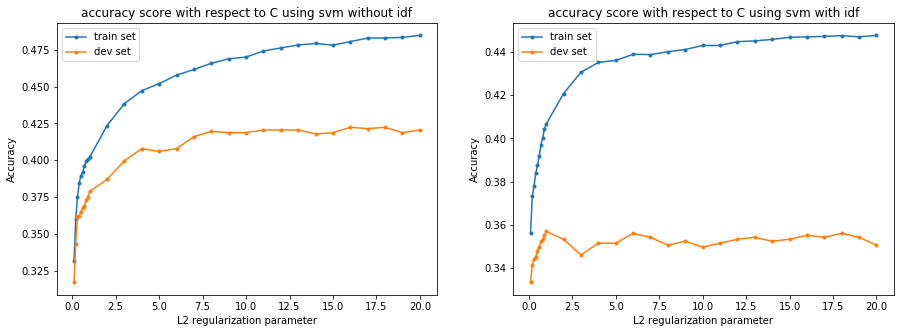

In [78]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

# We will try here an svm model and we will tune the regularization parameter
from sklearn.svm import SVC
accuracy_dev_svm = []
accuracy_train_svm = []
Cs_svm = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for C in Cs_svm :
    svm = SVC(kernel='linear',C=C)
    svm.fit(X_train_bov, y_train)
    accuracy_train_svm.append(svm.score(X_train_bov,y_train))
    accuracy_dev_svm.append(svm.score(X_dev_bov,y_dev))

accuracy_dev_svm_idf = []
accuracy_train_svm_idf = []
Cs_svm = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for C in Cs_svm :
    svm = SVC(kernel='linear',C=C)
    svm.fit(X_train_bov_idf, y_train)
    accuracy_train_svm_idf.append(svm.score(X_train_bov_idf,y_train))
    accuracy_dev_svm_idf.append(svm.score(X_dev_bov_idf,y_dev))
    
index_svm = np.argmax(accuracy_dev_svm)
index_svm_idf = np.argmax(accuracy_dev_svm_idf)

C_final_svm = Cs_svm[index_svm]
C_final_svm_idf= Cs_svm[index_svm_idf]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(Cs_svm, accuracy_train_svm, '.-', label='train set')
plt.plot(Cs_svm, accuracy_dev_svm, '.-',label='dev set')
plt.title('accuracy score with respect to C using svm without idf')
plt.legend()
plt.xlabel("L2 regularization parameter")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.plot(Cs_svm, accuracy_train_svm_idf, '.-', label='train set')
plt.plot(Cs_svm, accuracy_dev_svm_idf, '.-',label='dev set')
plt.title('accuracy score with respect to C using svm with idf')
plt.legend()
plt.xlabel("L2 regularization parameter")
plt.ylabel("Accuracy")


print('Accuracy on train set with best parameter C={:.4f} without idf: {:4f}'.format(C_final,accuracy_train_svm[index_svm]))
print('Accuracy on train set with best parameter C={:.4f} with idf: {:4f}'.format(C_final_idf,accuracy_train_svm_idf[index_svm_idf]))
print('\n')
print('Accuracy on dev set with best parameter C={:.4f} using svm without idf: {:4f}'.format(C_final_svm,accuracy_dev_svm[index_svm]))
print('Accuracy on dev set with best parameter C={:.4f} using svm with idf: {:4f}'.format(C_final_svm_idf,accuracy_dev_svm_idf[index_svm_idf]))



In [72]:
#the svm works a little better than the reglog
svm = SVC(kernel='linear',C=C_final_svm)
svm.fit(X_train_bov, y_train)
y_pred = svm.predict(X_test_bov)
np.savetxt('XXX_bow_y_test_sst.txt', y_pred, fmt='%d', delimiter='\n')

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [80]:
import tensorflow as tf

In [175]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(nb_words=50000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=True,split=' ')
tokenizer.fit_on_texts(train_raw)

X_train = tokenizer.texts_to_sequences(train_raw)
X_dev = tokenizer.texts_to_sequences(dev_raw)
X_test = tokenizer.texts_to_sequences(test_raw)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [176]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train)
X_dev = pad_sequences(X_dev,maxlen=X_train.shape[1])
X_test = pad_sequences(X_test,maxlen=X_train.shape[1])

## 4.2 - Design and train your model

In [177]:
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.

config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)

In [178]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Dropout,Bidirectional

embed_dim  = 300  # word embedding dimension
nhid       = 32  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5
model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(Dropout(0.2))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='sigmoid'))

In [179]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
dropout (Dropout)            (None, None, 300)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                42624     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 15,042,789
Trainable params: 15,042,789
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8512/8544 [============================>.] - ETA: 0s - loss: 1.5610 - acc: 0.2993
Epoch 00001: val_acc improved from -inf to 0.33333, saving model to data/model/lstm.hdf5
8544/8544 [==============================] - 45s 5ms/sample - loss: 1.5611 - acc: 0.2996 - val_loss: 1.5065 - val_acc: 0.3333
Epoch 2/10
8512/8544 [============================>.] - ETA: 0s - loss: 1.3062 - acc: 0.4489
Epoch 00002: val_acc improved from 0.33333 to 0.41689, saving model to data/model/lstm.hdf5
8544/8544 [==============================] - 43s 5ms/sample - loss: 1.3058 - acc: 0.4489 - val_loss: 1.3717 - val_acc: 0.4169
Epoch 3/10
8512/8544 [============================>.] - ETA: 0s - loss: 0.9359 - acc: 0.6293
Epoch 00003: val_acc did not improve from 0.41689
8544/8544 [==============================] - 43s 5ms/sample - loss: 0.9367 - acc: 0.6287 - val_loss: 1.5329 - val_acc: 0.3878
Epoch 4/10
8512/8544 [============================>.] - ETA: 0s 

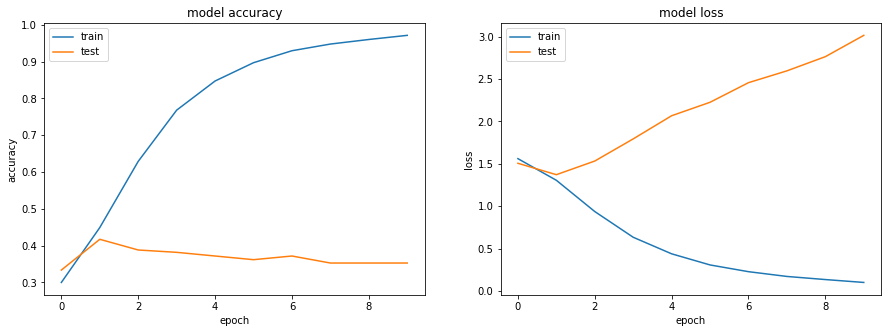

In [180]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# ADAPT CODE BELOW
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
y_train_code = to_categorical(y_train)
y_dev_code = to_categorical(y_dev)

checkpointer = ModelCheckpoint(filepath='data/model/lstm.hdf5', verbose=1,
                                               save_best_only=True, monitor='val_acc')
bs = 32

n_epochs = 10

history = model.fit(X_train, y_train_code, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_dev, y_dev_code),callbacks=[checkpointer])

# plot history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
# plot history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [183]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
model = load_model('data/model/lstm.hdf5')
y_pred = np.argmax(model.predict(X_test), axis = 1)
np.savetxt('logreg_lstm_y_test_sst.txt', y_pred, fmt='%d', delimiter='\n') #!!remember to delete last newline!!

## 4.3 - innovate !

In [222]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=100000)
embedding_dim = 300
embeddings_dict = {}
embeddings_matrix = []
dataset = train_raw + dev_raw + test_raw
for sentence in dataset:
    for word in sentence.split():
        if word not in embeddings_dict.keys():
            if word in word2vec.words:
                embeddings_dict[word]= word2vec.encode(word)
                embeddings_matrix.append(word2vec.encode(word))
            else :
                embeddings_dict[word] = np.random.rand(embedding_dim)
                embeddings_matrix.append(embeddings_dict[word])
embeddings_matrix = np.array(embeddings_matrix)

Loaded 100000 pretrained word vectors


In [236]:
embed_dim  = 300  # word embedding dimension
nhid       = 100  # number of hidden units in the LSTM
vocab_size = embeddings_matrix.shape[0]  # size of the vocabulary
n_classes  = 5
kernel_size = 3
filters = 32
pool_size = 3

model = Sequential()
model.add(Embedding(vocab_size, embed_dim,input_length=X_train.shape[1], trainable = True, weights = [embeddings_matrix]))
model.add(Conv1D(250,5,padding='valid',activation='relu',strides=1))
#model.add(MaxPooling1D(pool_size=pool_size))

model.add(Conv1D(64,3,padding='valid',activation='relu',strides=1))

model.add(MaxPooling1D(pool_size=3))
#model.add(GlobalMaxPooling1D())

model.add(Flatten())
model.add(Dense(n_classes, activation='sigmoid'))

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
y_train_code = to_categorical(y_train)
y_dev_code = to_categorical(y_dev)

checkpointer = ModelCheckpoint(filepath='data/model/cnn.hdf5', verbose=1,
                                               save_best_only=True, monitor='val_acc')
bs = 32

n_epochs = 10

history = model.fit(X_train, y_train_code, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_dev, y_dev_code),callbacks=[checkpointer])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 48, 300)           4178100   
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 44, 250)           375250    
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 42, 64)            48064     
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 14, 64)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 5)                 4485      
Total params: 4,605,899
Trainable params: 4,605,899
Non-trainable params: 0
_________________________________________________________________


C:\Users\abdel\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 34s 4ms/step - loss: 1.5585 - acc: 0.2877 - val_loss: 1.4869 - val_acc: 0.3497

Epoch 00001: val_acc improved from -inf to 0.34968, saving model to data/model/lstm_trained.hdf5
Epoch 2/10
8544/8544 [==============================] - 31s 4ms/step - loss: 1.2956 - acc: 0.4267 - val_loss: 1.4038 - val_acc: 0.3996

Epoch 00002: val_acc improved from 0.34968 to 0.39964, saving model to data/model/lstm_trained.hdf5
Epoch 3/10
8544/8544 [==============================] - 33s 4ms/step - loss: 0.8147 - acc: 0.6689 - val_loss: 1.7214 - val_acc: 0.3769

Epoch 00003: val_acc did not improve from 0.39964
Epoch 4/10
8544/8544 [==============================] - 32s 4ms/step - loss: 0.3156 - acc: 0.8832 - val_loss: 2.3721 - val_acc: 0.3370

Epoch 00004: val_acc did not improve from 0.39964
Epoch 5/10
8544/8544 [==============================] - 33s 4ms/step - loss: 0.1260 - acc: 0.9567 - val_loss: 3

In [240]:
model = load_model('data/model/cnn.hdf5')
y_pred = np.argmax(model.predict(X_test), axis = 1)
np.savetxt('XXX_XXX_y_test_sst.txt', y_pred, fmt='%d', delimiter='\n') #!!remember to delete last newline!!